# Deep Reinforcement Learning <em> in Action </em>
## N-Armed Bandits
### Chapter 2

In [4]:
import numpy as np
import torch as th
from torch.autograd import Variable
from matplotlib import pyplot as plt
import random
%matplotlib inline

This defines the main contextual bandit class we'll be using as our environment/simulator to train a neural network.

In [5]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward
    

Here we define our simple neural network model using PyTorch

In [6]:
def softmax(av, tau=1.12):
    n = len(av)
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

arms = 10
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, arms, 100, arms

model = th.nn.Sequential(
    th.nn.Linear(D_in, H),
    th.nn.ReLU(),
    th.nn.Linear(H, D_out),
    th.nn.ReLU(),
)

loss_fn = th.nn.MSELoss(size_average=False)

env = ContextBandit(arms)

Next we define the training function, which accepts an instantiated ContextBandit object.

In [7]:
def train(env):
    epochs = 5000
    #one-hot encode current state
    cur_state = Variable(th.Tensor(one_hot(arms,env.get_state())))
    reward_hist = np.zeros(50)
    reward_hist[:] = 5
    runningMean = np.average(reward_hist)
    learning_rate = 1e-2
    optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
    plt.xlabel("Plays")
    plt.ylabel("Mean Reward")
    for i in range(epochs):
        y_pred = model(cur_state) #produce reward predictions
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) #turn reward distribution into probability distribution
        av_softmax /= av_softmax.sum() #make sure total prob adds to 1
        choice = np.random.choice(arms, p=av_softmax) #sample an action
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = Variable(th.Tensor(one_hot_reward))
        loss = loss_fn(y_pred, reward)
        if i % 50 == 0:
            runningMean = np.average(reward_hist)
            reward_hist[:] = 0
            plt.scatter(i, runningMean)
        reward_hist[i % 50] = cur_reward
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        cur_state = Variable(th.Tensor(one_hot(arms,env.get_state())))

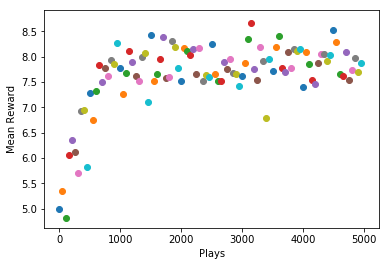

In [8]:
train(env)